In [1]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap
from PlotFuncs import *
from LabFuncs import *
from Params import *
from HaloFuncs import *
from scipy.stats import norm
import pandas

# Load shards
df = pandas.read_csv('../data/FitShards.csv')
names = df.group_id
nshards = size(names)
velocities = zeros(shape=(nshards,3))
dispersions = zeros(shape=(nshards,3))
velocities[0:(nshards),0] = df.vx # stream velocities
velocities[0:(nshards),1] = df.vy
velocities[0:(nshards),2] = df.vz
dispersions[0:(nshards),0] = df.sigx # dispersion tensors
dispersions[0:(nshards),1] = df.sigy
dispersions[0:(nshards),2] = df.sigz
pops = df.population
Psun = df.Psun
Psun[Psun==inf] = 0.0
pops[1] = 30.0
weights = pops#*norm.pdf(Psun,loc=0.0,scale=1.0)/norm.pdf(0.0,loc=0.0,scale=1.0)
weights /= sum(weights)



/Users/ciaranohare/anaconda/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a 2.7.x release that supports hmac.compare_digest as soon as possible.
  utils.DeprecatedIn23,


/Users/ciaranohare/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/ciaranohare/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [48]:
# Figure setup
from mpl_toolkits.basemap import shiftgrid


# Set up binning
n = 200
ph = flipud(linspace(-pi, pi-2*pi/n, n))
th = linspace(0,pi, n/2)
PH,TH = meshgrid(ph,th)
X = cos(PH)*sin(TH)
Y = -sin(PH)*sin(TH)
Z = cos(TH)
ii = 0
q = zeros(shape=(n*n/2,3))
for i in range(0,n/2):
    for j in range(0,n):
        q[ii,:] = array([X[i,j],Y[i,j],Z[i,j]])
        ii = ii+1
        
def convertmap(fv3D):
    fv_map = zeros(shape=(n/2,n))
    ii = 0
    for i in range(0,n/2):
        for j in range(0,n):
            fv_map[i,j] = fv3D[ii]
            ii = ii+1
    fv_map = flipud(fv_map)
    return fv_map



# v binning
nv = 1000
v_vals = linspace(0.1,600,nv)

# Halo params
HaloModel = SHMpp
v0 = HaloModel.RotationSpeed
v_esc = HaloModel.EscapeSpeed
sig_beta = HaloModel.SausageDispersionTensor
sig_iso = array([1.0,1.0,1.0])*v0/sqrt(2.0)
day = 67.0 

# Smooth
fv3D_Saus = zeros(shape=n*n/2)
fv3D_Iso = zeros(shape=n*n/2)
for j in range(0,nv):
    fv3D_Iso += VelocityDist_Triaxial(-v_vals[j]*q,day,sig_iso)
    fv3D_Saus += VelocityDist_Triaxial(-v_vals[j]*q,day,sig_beta)
fv_map_Saus = convertmap(fv3D_Saus)
fv_map_Iso = convertmap(fv3D_Iso)
    
# Shards
fv_map_shards = zeros(shape=(n/2,n,nshards))
for isub in range(0,nshards):
    v_str = velocities[isub,:]
    x_str = v_str/sqrt(sum(v_str**2.0))
    sig_s = dispersions[isub,:]
    fv3D = zeros(shape=(n*n/2))
    for j in range(0,nv):
        fv3D += weights[isub]*VelocityDist_Triaxial(-v_vals[j]*q,day,sig_s,v_shift=v_str)
    print isub
    fv_map_shards[:,:,isub] = convertmap(fv3D)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68


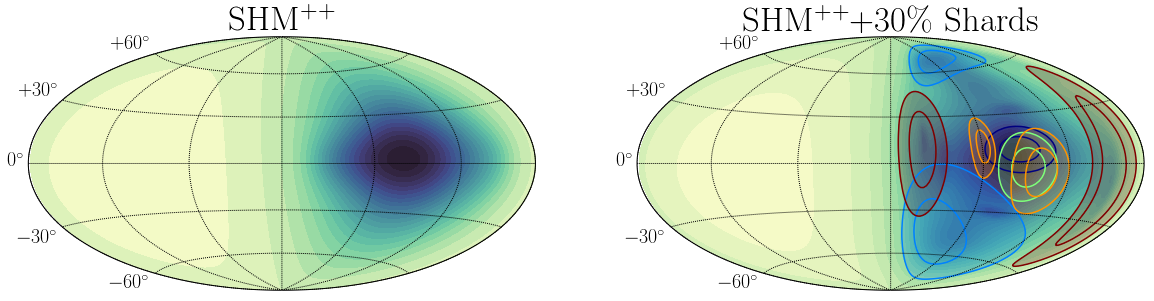

In [70]:
from IPython.display import clear_output

fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

import cmocean
cmap = cmocean.cm.deep

eta = 0.2
xi = 0.3
fv0 = (1-eta)*fv_map_Iso + eta*fv_map_Saus
fv_tot = (1-xi)*fv0 + xi*sum(fv_map_shards,2)



plt.sca(ax1)
m = Basemap(projection='hammer',lon_0=0.0,resolution='c',celestial=True)
m.contourf(PH*180/pi, TH*180/pi-90.0,fv0,30,cmap=cmap,latlon=True)
m.contourf(PH*180/pi, TH*180/pi-90.0,fv0,30,cmap=cmap,latlon=True)
m.contourf(PH*180/pi, TH*180/pi-90.0,fv0,30,cmap=cmap,latlon=True)

clear_output()

m.drawparallels(arange(-90.,120.,30.),labels=[1,0,0,0],color='k',fontsize=20) # draw parallels
m.drawmeridians(arange(0.,420.,60.),color='k',fontsize=20) # draw meridians
plt.title(r'SHM$^{++}$',fontsize=35)

plt.sca(ax2)
m = Basemap(projection='hammer',lon_0=0.0,resolution='c',celestial=True)
m.contourf(PH*180/pi, TH*180/pi-90.0,fv_tot,30,cmap=cmap,latlon=True)
m.contourf(PH*180/pi, TH*180/pi-90.0,fv_tot,30,cmap=cmap,latlon=True)
m.contourf(PH*180/pi, TH*180/pi-90.0,fv_tot,30,cmap=cmap,latlon=True)

clear_output()

col_ex = (cm.jet(linspace(0,1,5)))

# S1
isub = 0
m.contour(PH*180/pi, TH*180/pi-90.0,fv_map_shards[:,:,isub]/amax(fv_map_shards[:,:,isub]),colors=col_ex[0,:],levels=[0.1,0.5,1.0],latlon=True)
m.contourf(PH*180/pi, TH*180/pi-90.0,fv_map_shards[:,:,isub]/amax(fv_map_shards[:,:,isub]),colors=(col_ex[0,:],),levels=[0.1,0.5,1.0],latlon=True,alpha=0.2)
clear_output()

# S2
isub = 1
m.contour(PH*180/pi, TH*180/pi-90.0,fv_map_shards[:,:,isub]/amax(fv_map_shards[:,:,isub]),colors=col_ex[1,:],levels=[0.1,0.5,1.0],latlon=True)
m.contourf(PH*180/pi, TH*180/pi-90.0,fv_map_shards[:,:,isub]/amax(fv_map_shards[:,:,isub]),colors=(col_ex[1,:],),levels=[0.1,0.5,1.0],latlon=True,alpha=0.2)
clear_output()
isub = 2
m.contour(PH*180/pi, TH*180/pi-90.0,fv_map_shards[:,:,isub]/amax(fv_map_shards[:,:,isub]),colors=col_ex[1,:],levels=[0.1,0.5,1.0],latlon=True)
m.contourf(PH*180/pi, TH*180/pi-90.0,fv_map_shards[:,:,isub]/amax(fv_map_shards[:,:,isub]),colors=(col_ex[1,:],),levels=[0.1,0.5,1.0],latlon=True,alpha=0.2)
clear_output()

# Rg1
isub = 4
m.contour(PH*180/pi, TH*180/pi-90.0,fv_map_shards[:,:,isub]/amax(fv_map_shards[:,:,isub]),colors=col_ex[2,:],levels=[0.1,0.5,1.0],latlon=True)
m.contourf(PH*180/pi, TH*180/pi-90.0,fv_map_shards[:,:,isub]/amax(fv_map_shards[:,:,isub]),colors=(col_ex[2,:],),levels=[0.1,0.5,1.0],latlon=True,alpha=0.2)
clear_output()


# Rg3
isub = 6
m.contour(PH*180/pi, TH*180/pi-90.0,fv_map_shards[:,:,isub]/amax(fv_map_shards[:,:,isub]),colors=col_ex[3,:],levels=[0.1,0.5,1.0],latlon=True)
m.contourf(PH*180/pi, TH*180/pi-90.0,fv_map_shards[:,:,isub]/amax(fv_map_shards[:,:,isub]),colors=(col_ex[3,:],),levels=[0.1,0.5,1.0],latlon=True,alpha=0.2)
clear_output()
isub = 7
m.contour(PH*180/pi, TH*180/pi-90.0,fv_map_shards[:,:,isub]/amax(fv_map_shards[:,:,isub]),colors=col_ex[3,:],levels=[0.1,0.5,1.0],latlon=True)
m.contourf(PH*180/pi, TH*180/pi-90.0,fv_map_shards[:,:,isub]/amax(fv_map_shards[:,:,isub]),colors=(col_ex[3,:],),levels=[0.1,0.5,1.0],latlon=True,alpha=0.2)
clear_output()



# Cand14
isub = 20
m.contour(PH*180/pi, TH*180/pi-90.0,fv_map_shards[:,:,isub]/amax(fv_map_shards[:,:,isub]),colors=col_ex[4,:],levels=[0.1,0.5,1.0],latlon=True)
m.contourf(PH*180/pi, TH*180/pi-90.0,fv_map_shards[:,:,isub]/amax(fv_map_shards[:,:,isub]),colors=(col_ex[4,:],),levels=[0.1,0.5,1.0],latlon=True,alpha=0.2)
clear_output()
isub = 21
m.contour(PH*180/pi, TH*180/pi-90.0,fv_map_shards[:,:,isub]/amax(fv_map_shards[:,:,isub]),colors=col_ex[4,:],levels=[0.1,0.5,1.0],latlon=True)
m.contourf(PH*180/pi, TH*180/pi-90.0,fv_map_shards[:,:,isub]/amax(fv_map_shards[:,:,isub]),colors=(col_ex[4,:],),levels=[0.1,0.5,1.0],latlon=True,alpha=0.2)
clear_output()

m.drawparallels(arange(-90.,120.,30.),labels=[1,0,0,0],color='k',fontsize=20) # draw parallels
m.drawmeridians(arange(0.,420.,60.),color='k',fontsize=20) # draw meridians
plt.title(r'SHM$^{++}$+30\% Shards',fontsize=35)



plt.show()
pltname = 'ShardsFlux'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

In [67]:
names[20]

'Cand14a'

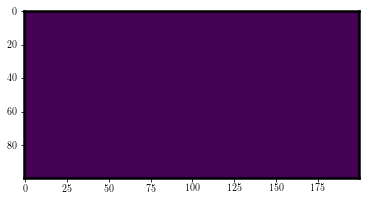

In [23]:
plt.imshow(fv_map_shards[:,:,0])
plt.show()